<a href="https://colab.research.google.com/github/Nicolas13210/BIS_Project2023/blob/main/BIS_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%pip install pm4py
import pandas as pd
import pm4py as pm4py
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from google.colab import drive
from pm4py.objects.log.util import dataframe_utils

## Clearing the data

To use the dataset on google colab, we upload it on google drive and then, we connect google colab to the drive to have access to the dataset.

In [ ]:
drive.mount('/content/drive')
url = "/content/drive/MyDrive/dataset/BPI2016_Clicks_Logged_In.csv"
log_df = pd.read_csv(url,sep=';',encoding='latin-1"')

Now that the dataset is uploaded, we can start discovering it. First, we will take a look to the different columns and the number of non-null values.

In [ ]:
log_df.info(verbose=True,show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7174934 entries, 0 to 7174933
Data columns (total 20 columns):
 #   Column                 Non-Null Count    Dtype 
---  ------                 --------------    ----- 
 0   CustomerID             7174934 non-null  int64 
 1   AgeCategory            7174934 non-null  object
 2   Gender                 7174934 non-null  object
 3   Office_U               7174934 non-null  int64 
 4   Office_W               7174934 non-null  int64 
 5   SessionID              7174934 non-null  int64 
 6   IPID                   7174934 non-null  int64 
 7   TIMESTAMP              7174934 non-null  object
 8   VHOST                  7174934 non-null  object
 9   URL_FILE               7174934 non-null  object
 10  PAGE_NAME              7174934 non-null  object
 11  REF_URL_category       514099 non-null   object
 12  page_load_error        7174934 non-null  int64 
 13  page_action_detail     11150 non-null    object
 14  tip                    5429 non-nu

With this result, we can see that columns *service_detail, page_action_detail,tip* and their equivalent in english are mostly filled with null-values. Is also the case for *xps_info*  That's why we will remove them. We will also remove *URL_FILE* column because the name of the page is enough information for us.

In [ ]:
useless_column = ['service_detail','page_action_detail','tip_EN','xps_info','page_action_detail_EN','service_detail_EN','tip','URL_FILE']
log_df.drop(useless_column,axis=1,inplace=True)


We now have an event log more readable. Let's take a look to the number of events and cases we have.

In [ ]:
print('There are {} events\nThere are {} cases'.format(len(log_df),len(log_df['SessionID'].unique())))

There are 7174934 events
There are 660270 cases


Now, we want to have some informations about the different events of the event log. So, we will look at the frequencie of each event in the dataset.

In [ ]:
frequencies = log_df['PAGE_NAME'].value_counts()
frequencies

taken                      1823175
vacatures_bij_mijn_cv       953969
mijn_cv                     880597
home                        583545
vacatures_zoeken            582645
                            ...   
thematische-publicaties          1
Overheid                         1
tsjechie                         1
roemenie                         1
ptl173177                        1
Name: PAGE_NAME, Length: 600, dtype: int64

Here, we can see that we have 600 different events but some of them are rarely used. In order to simplify our event log, we will only keep events that represent more thant 90% of the entire dataset. 

In [ ]:
frequencies=frequencies.cumsum()
usual_pages = []
threshold = 0.9*len(log_df)
k=0
while(frequencies[k]<threshold):
  usual_pages.append(frequencies.index[k])
  k+=1

print('There are {} events that represent more than 90% of the events'.format(len(usual_pages)))

filtered_log = log_df[log_df['PAGE_NAME'].isin(usual_pages)]
print('There are {} events\nThere are {} cases'.format(len(filtered_log),len(filtered_log['SessionID'].unique())))

There are 11 events that represent more than 90% of the events
There are 6346651 events
There are 645391 cases


Here, we already have an interesting information. In the 600 pages accessible in the website, only 11 of them represents more than 90% of the traffic. We can interprate the fact that a lot of pages are useless in different ways.


*   Those pages are used only for very specific cases which are not representated in our event log (maybe because we have only logged in people)
*   Those pages are not accessible anymore
*   Users are not aware that such pages exist

We decided to remove only the unusual event from our dataset and not the full case because having one unusual event doesn't mean that the rest of the trace is abnormal. It's a way to simplify the dataset and reduce a little bit the complexity of the event log.

Let's see the distribution of those events.

<Axes: title={'center': 'frequencie of each event'}>

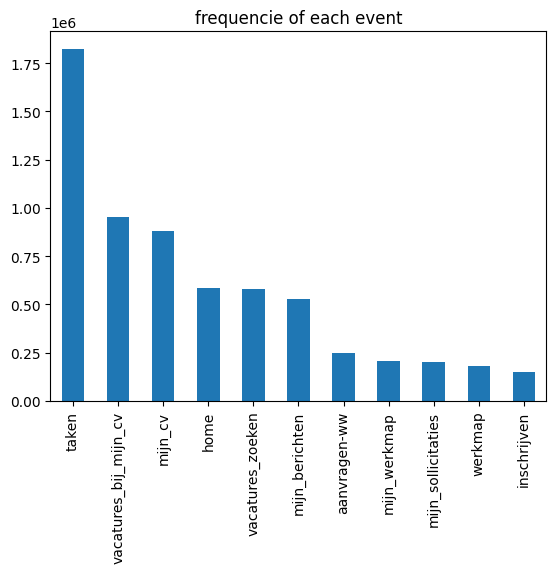

In [ ]:
frequencies_final = filtered_log['PAGE_NAME'].value_counts()
frequencies_final.plot.bar(title="frequencie of each event")

From left to right, we have : job (or tasks) , vacancies to my cv, my cv, search for vacancies, my messages, requests, my workbook, my applications, workbook and register.
Here, we can clearly see that people are mostly searching job corresponding to their CV and that is why they have to update it regularly. The page *taken* is the most visited, we can assume that this page is a kind of dashboard where we can see a lot of informations like the lasts vacancies, notifications...


We will now use pm4py dataframe to perform some other calculations on the event log.

In [ ]:
filtered_log.rename(columns={'SessionID': 'case:concept:name', 'TIMESTAMP': 'time:timestamp', 'PAGE_NAME': 'concept:name'}, inplace=True)
filtered_log = dataframe_utils.convert_timestamp_columns_in_df(filtered_log)
event_log = pm4py.format_dataframe(filtered_log)

Here, there is a function to get the number of events and cases in the event log.

In [ ]:
def getDetail(dataframe):
  num_events = len(dataframe)
  num_cases = len(dataframe['case:concept:name'].unique())
  print("Number of events: {}\nNumber of cases: {}".format(num_events, num_cases))
getDetail(event_log)

Number of events: 6346651
Number of cases: 645391


To keep reducing the size of the event log, we will remove all event with a page load error because it's not a normal behaviour of the website.

In [ ]:
previous_num_event = len(event_log)
previous_num_cases = len(event_log['case:concept:name'].unique())
event_log = pm4py.filter_event_attribute_values(event_log,"page_load_error",[1],retain=False)
getDetail(event_log)
print("We kept {} % of our events and {} % of cases".format(len(event_log)*100/previous_num_event,len(event_log['case:concept:name'].unique())/previous_num_cases *100 ))


Number of events: 5551377
Number of cases: 616171
We kept 87.46939133725803 % of our events and 95.4725120120981 % of cases


Here, we can see that around 800 000 events have a load error. It's more than 10% of the events. Once again, we only remove the event and not the whole case because users have probably reloaded the same page after a connexion error.

Now, we will focus on the duration of events and cases. First, we will keep only events that last at least 1 second.

In [ ]:
event_log = pm4py.filter_case_performance(event_log,1,float('inf'))
getDetail(event_log)

Number of events: 5493039
Number of cases: 557845


We removed around 100 000 events and around 60 000 cases which is not a lot compared to the size of the dataset. Now that we don't have null-duration events anymore, we can take a look at the duration distribution.

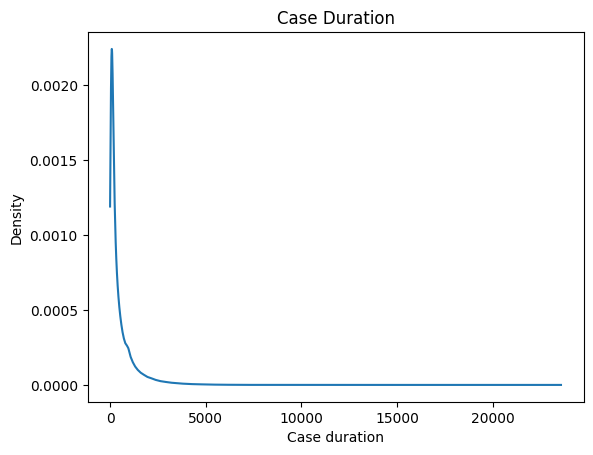

In [ ]:
pm4py.view_case_duration_graph(event_log)

We can see that most of the sessions are very short (around 10 minutes). 

We can also get some informations about when users use the website.

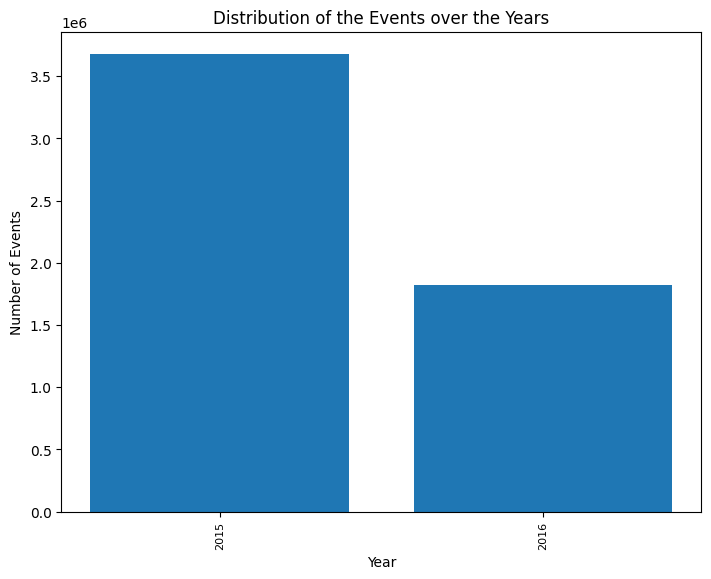

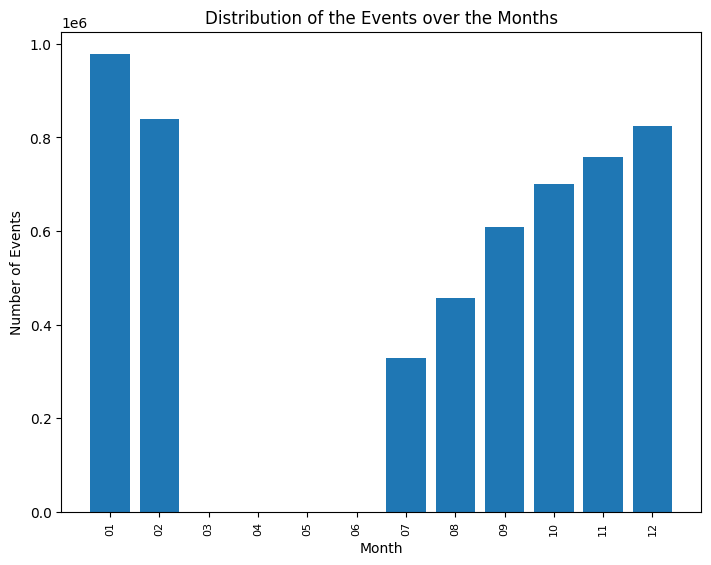

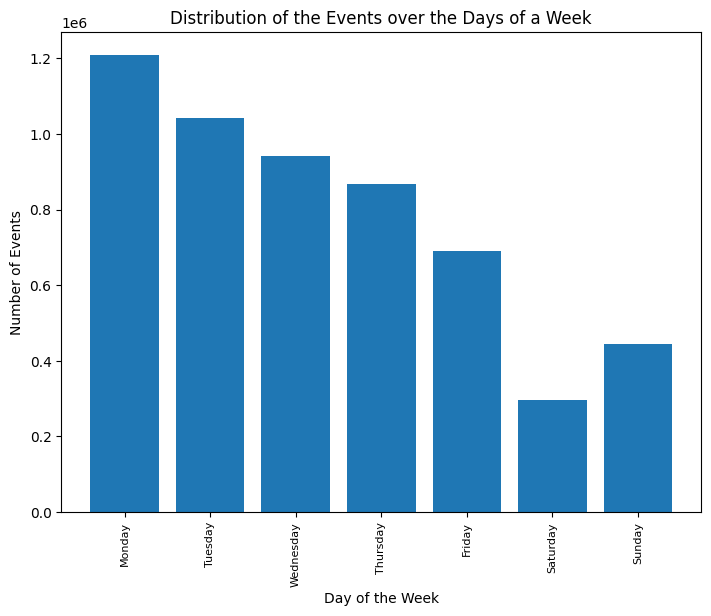

In [ ]:
pm4py.view_events_distribution_graph(event_log, format='png', distr_type='years')
pm4py.view_events_distribution_graph(event_log, format='png', distr_type='months')
pm4py.view_events_distribution_graph(event_log, format='png', distr_type='days_week')

Here we can see that all the data was collected between July 2015 and February 2016.During this period we can clearly see that users are more connected at the beginning of the week than at the end.


Another information that can be interesting to us is the age and gender repartition. First, we will create a table with the proportion of men/women for each age category and also the ratio between the number of person in the age category compairs to the total number of person.

In [ ]:
age_category = event_log['AgeCategory'].unique()
size = len(event_log['case:concept:name'].unique())
age_category.sort()
women=[]
men=[]
nb_people=[]
for age in age_category:
  age_table = pm4py.filter_trace_attribute_values(event_log,'AgeCategory',[age])
  women_table = pm4py.filter_trace_attribute_values(age_table,'Gender',['V'])
  men_table = pm4py.filter_trace_attribute_values(age_table,'Gender',['M'])
  nb_women = len(women_table['case:concept:name'].unique())
  nb_men = len(men_table['case:concept:name'].unique())
  total = nb_women+nb_men
  women.append(nb_women/total)
  men.append(nb_men/total)
  nb_people.append(total/size)
stat_table = pd.DataFrame({'men':men,'women':women,'total':nb_people,"age":age_category})


Let's vizualize it

Text(0.5, 1.0, 'Ratio men/women')

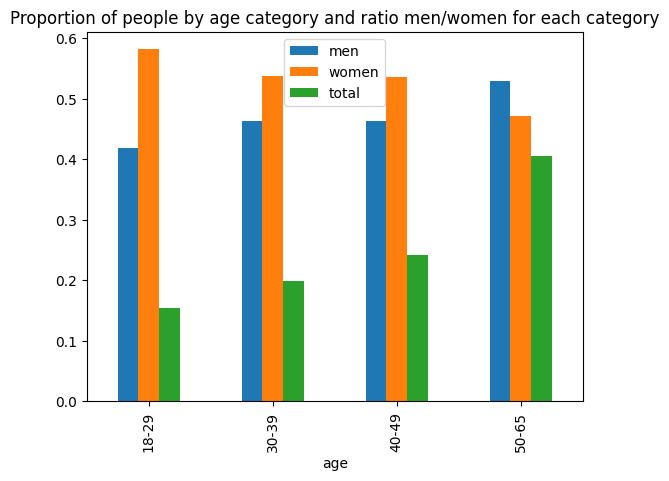

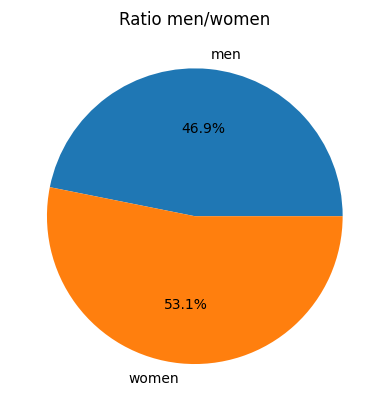

In [ ]:
stat_table.plot.bar(x='age', title="Proportion of people by age category and ratio men/women for each category")
fig, ax = plt.subplots()
ax.pie([stat_table['men'].sum(),stat_table['women'].sum()],labels = ['men','women'],autopct='%1.1f%%')
ax.set_title("Ratio men/women")

Here, we can see that the event log is quite balanced in terms of gender with a little bit more women than men. But, we can't say the same about the age repartition, they are way more older people than younger one.

## Finding models

### Clustering

Now that we know a little bit more about the event log, we will try to identify some clusters. To do so, we will convert each case into vectors and run the K-Means algorithm several times to find the good number of clusters.

Text(0, 0.5, 'SSE')

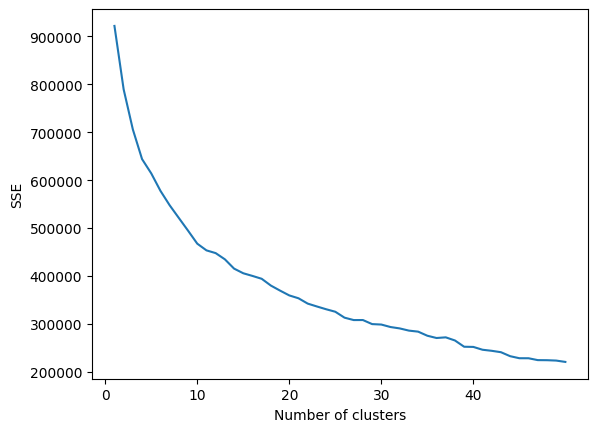

In [ ]:
features_df = pm4py.extract_features_dataframe(event_log,str_ev_attr=['concept:name'])
from sklearn.cluster import KMeans
norm_features = features_df.drop(['case:concept:name'],axis ='columns')
kmeans_kwargs = {"init":"random","n_init":10,"random_state":13160,} 
n=50
sse = []

for k in range(1,1+n):
  kmeans = KMeans(n_clusters=k,**kmeans_kwargs)
  kmeans.fit(norm_features)
  sse.append(kmeans.inertia_)

plt.plot(range(1,1+n),sse)
plt.xticks(np.arange(0,n,step=10))
plt.xlabel("Number of clusters")
plt.ylabel("SSE")

Here, we can see the sum square error in function of the number of clusters. A good choice for a number of cluster would be around 25 but in order to avoid repeating too many times the same thing, we will continue our investigation with only 10 clusters. So, let's associate to each sessionId, its corresponding cluster.

In [ ]:
kmeans = KMeans(n_clusters=10,**kmeans_kwargs)
kmeans.fit(norm_features)
features_df['cluster'] = kmeans.labels_

Now, we will create a list of 10 dataframes, one for each cluster.

In [ ]:
features_df = features_df.astype({'case:concept:name':str})
clusters = features_df['cluster'].unique()
clusters_log = []
initial_size = []
for k in clusters:
  cluster_cases = features_df[features_df['cluster'] == k]['case:concept:name'].tolist()
  cluster_log = event_log[event_log['case:concept:name'].isin(cluster_cases)]
  clusters_log.append(cluster_log)
  initial_size.append(len(cluster_log['case:concept:name'].unique())/size)
  

Here, we can see the repartition of our cases in the different clusters.

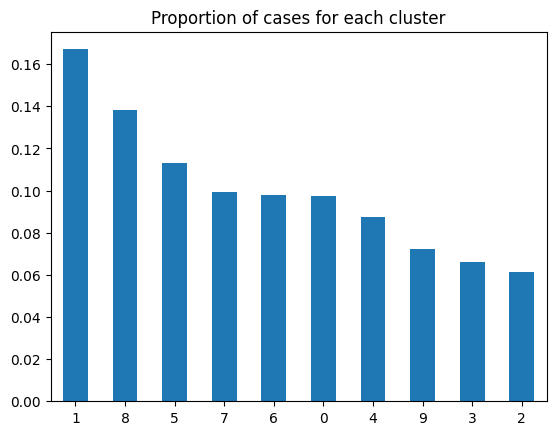

In [ ]:
init_clusters = pd.Series(initial_size)
init_clusters= init_clusters.sort_values(ascending=False)
ax = init_clusters.plot.bar(x='lab', y='val', rot=0,title = 'Proportion of cases for each cluster')

We see that the repartition is not even among all the cluster. They all represent at least 5% but the cluster 1 contains twice more cases that the cluster 2. We will have to take that into account when computing the conformance checking of our models.

### Start and end activities of each clusters

Now let's focus on the start and end activities of each cluster.

In [ ]:
start_values=[]
end_values = []
columns = {}
for column in event_log['concept:name'].unique():
  columns[column]=0
for k in range(len(clusters_log)):
  nb_cases = len(clusters_log[k]['case:concept:name'].unique())
  temp_start = columns
  temp_end = columns
  start_activities = pm4py.get_start_activities(clusters_log[k])
  end_activities = pm4py.get_end_activities(clusters_log[k])
  for key, value in start_activities.items():
    temp_start[key]=value/nb_cases
  for key, value in end_activities.items():
    temp_end[key]=value/nb_cases
  start_values.append(list(temp_start.values()))
  end_values.append(list(temp_end.values()))

start_activities = pd.DataFrame(np.array(start_values),columns=list(columns.keys()))
end_activities = pd.DataFrame(np.array(end_values),columns=list(columns.keys()))

<Axes: >

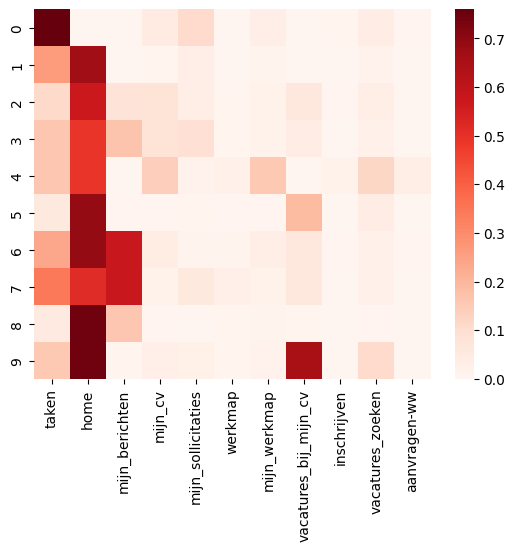

In [ ]:
sns.heatmap(start_activities, cmap="Reds")

Here, we can see that home page, my_messages page and the page for job announces corresponding to the CV are the pages which are most likely to be the start activitie for almost every cluster except one for which the most common start activitie is the tasks page.

<Axes: >

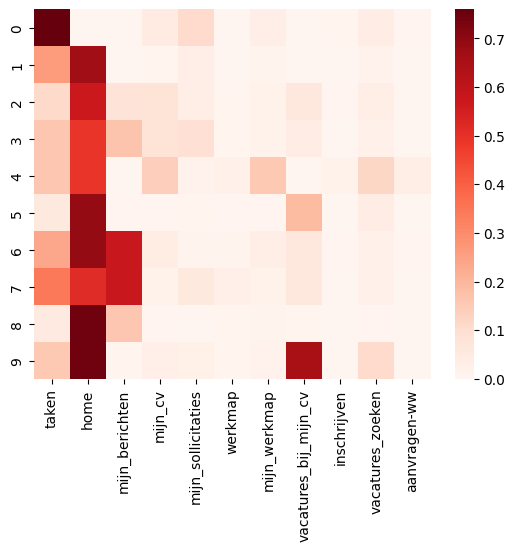

In [ ]:
sns.heatmap(end_activities, cmap="Reds")

We can see the same patern for the end activities, there are only four main end activities. 

So, for each cluster we will keep only traces beginning and ending with those 4 activities.

In [ ]:
dfs=[]
total = 0
main_activities = ['home','taken','vacatures_bij_mijn_cv','mijn_berichten']
for k in range(len(clusters_log)) :
  dfs.append(pm4py.filter_start_activities(clusters_log[k],main_activities,retain=True))
  dfs[k] = pm4py.filter_end_activities(dfs[k],main_activities,retain=True)
  total += len(dfs[k]['case:concept:name'].unique())

print('After filtering, we still have {} % of our cases'.format(round(total/len(event_log['case:concept:name'].unique() )*100,2)))

After filtering, we still have 55.76 % of our cases


We removed a large amount of cases but it doesn't mean that thoses cases are completely abnormal. We will compare them later with our models to see if the difference is significant.

Now, let's focus on variants distribution.

<BarContainer object of 10 artists>

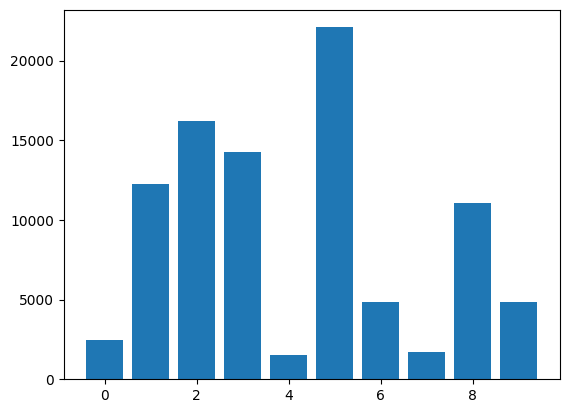

In [ ]:
var=[]
for k in range(len(dfs)):
  variants = pm4py.get_variants(dfs[k])
  var.append(len(variants))
fig,ax = plt.subplots()
ax.bar(range(10),var)

Here, we can see that variants distribution is not even at all, some clusters still have more than 10 000 variants whereas some others have less than 1000 variant. Clusters 0,4 and 7 are the one with the lowest number of variants. We can expect that the model for those clusters will be lighter than the other one.

## Conformance checking

Now, we will compute the model of our clusters and compare them to the original cluster, without any filtering (apart the one done to reduce the complexity of the event log)

In [ ]:
models=[]
conformances = []
for k in range(0,len(dfs)):
  net, im, fm = pm4py.discover_petri_net_inductive(dfs[k])
  tbr_diagnostics = pm4py.conformance_diagnostics_token_based_replay(clusters_log[k], net, im, fm)
  conformances.append(tbr_diagnostics)
  models.append([net,im,fm])

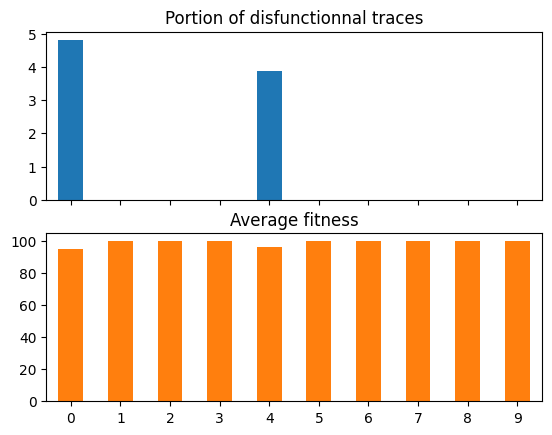

In [ ]:
portion_disfunctionnal=[]
fitness=[]
for k in range(len(conformances)):
  diagnostics_df = pd.DataFrame.from_dict(conformances[k])
  nb_disfunctionnal = len(diagnostics_df.index[diagnostics_df['trace_fitness'] < 0.8].tolist())
  portion_disfunctionnal.append(nb_disfunctionnal/len(clusters_log[k]['case:concept:name'].unique())*100)
  fitness.append(diagnostics_df['trace_fitness'].mean() *100)
conformance_table = pd.DataFrame({'Portion of disfunctionnal traces':portion_disfunctionnal,'Average fitness':fitness})
axes = conformance_table.plot.bar(rot=0, subplots=True, legend=False)

With this two graphs, we can see that our models are quite efficient, their average fitness is very high and their are a lot cases with a fitness above 80%. There is only two clusters with a lower accuracy: the clusters 0 and 4 which are not the clusters with the most cases. In those clusters, there are more than 3% of the cases which don't fit. We can assume that taking more clusters at the beginning could have reduce this number. 
Now, we will take a look to those disfunctionnal traces to see if they don't fit at all or if it's just a small difference.

In [ ]:
cluster_disfunctionnal = [0,4]
for k in cluster_disfunctionnal:
  diagnostics_df = pd.DataFrame.from_dict(conformances[k])
  disfunctionnal_traces_id = diagnostics_df.index[diagnostics_df['trace_fitness'] < 0.8].tolist()
  disfunctionnal_traces = diagnostics_df.take(disfunctionnal_traces_id)
  print('Average fitneess of disfunctionnal case for the cluster {} : {}%'.format(k,round(disfunctionnal_traces['trace_fitness'].mean(),3)*100))


Average fitneess of disfunctionnal case for the cluster 0 : 75.8%
Average fitneess of disfunctionnal case for the cluster 4 : 77.8%


Here, we can see that disfunctionnal cases are not very far from the model. We can now affirm that even if we remove a lot of cases based on the start and end activities,our models are still quite good. That confirme the fact that the order of the events are not really important, what matters is the presence or not of an event in the case. Of course, we can't forget that we removed events that were unusual but those events represent less than 10%. With those unusual events, the fitness would be lower but not necassary by a lot because having one unusual event doesn't mean that the whole case doesn't fit at all.

## Analysing
Let's take a look to some models

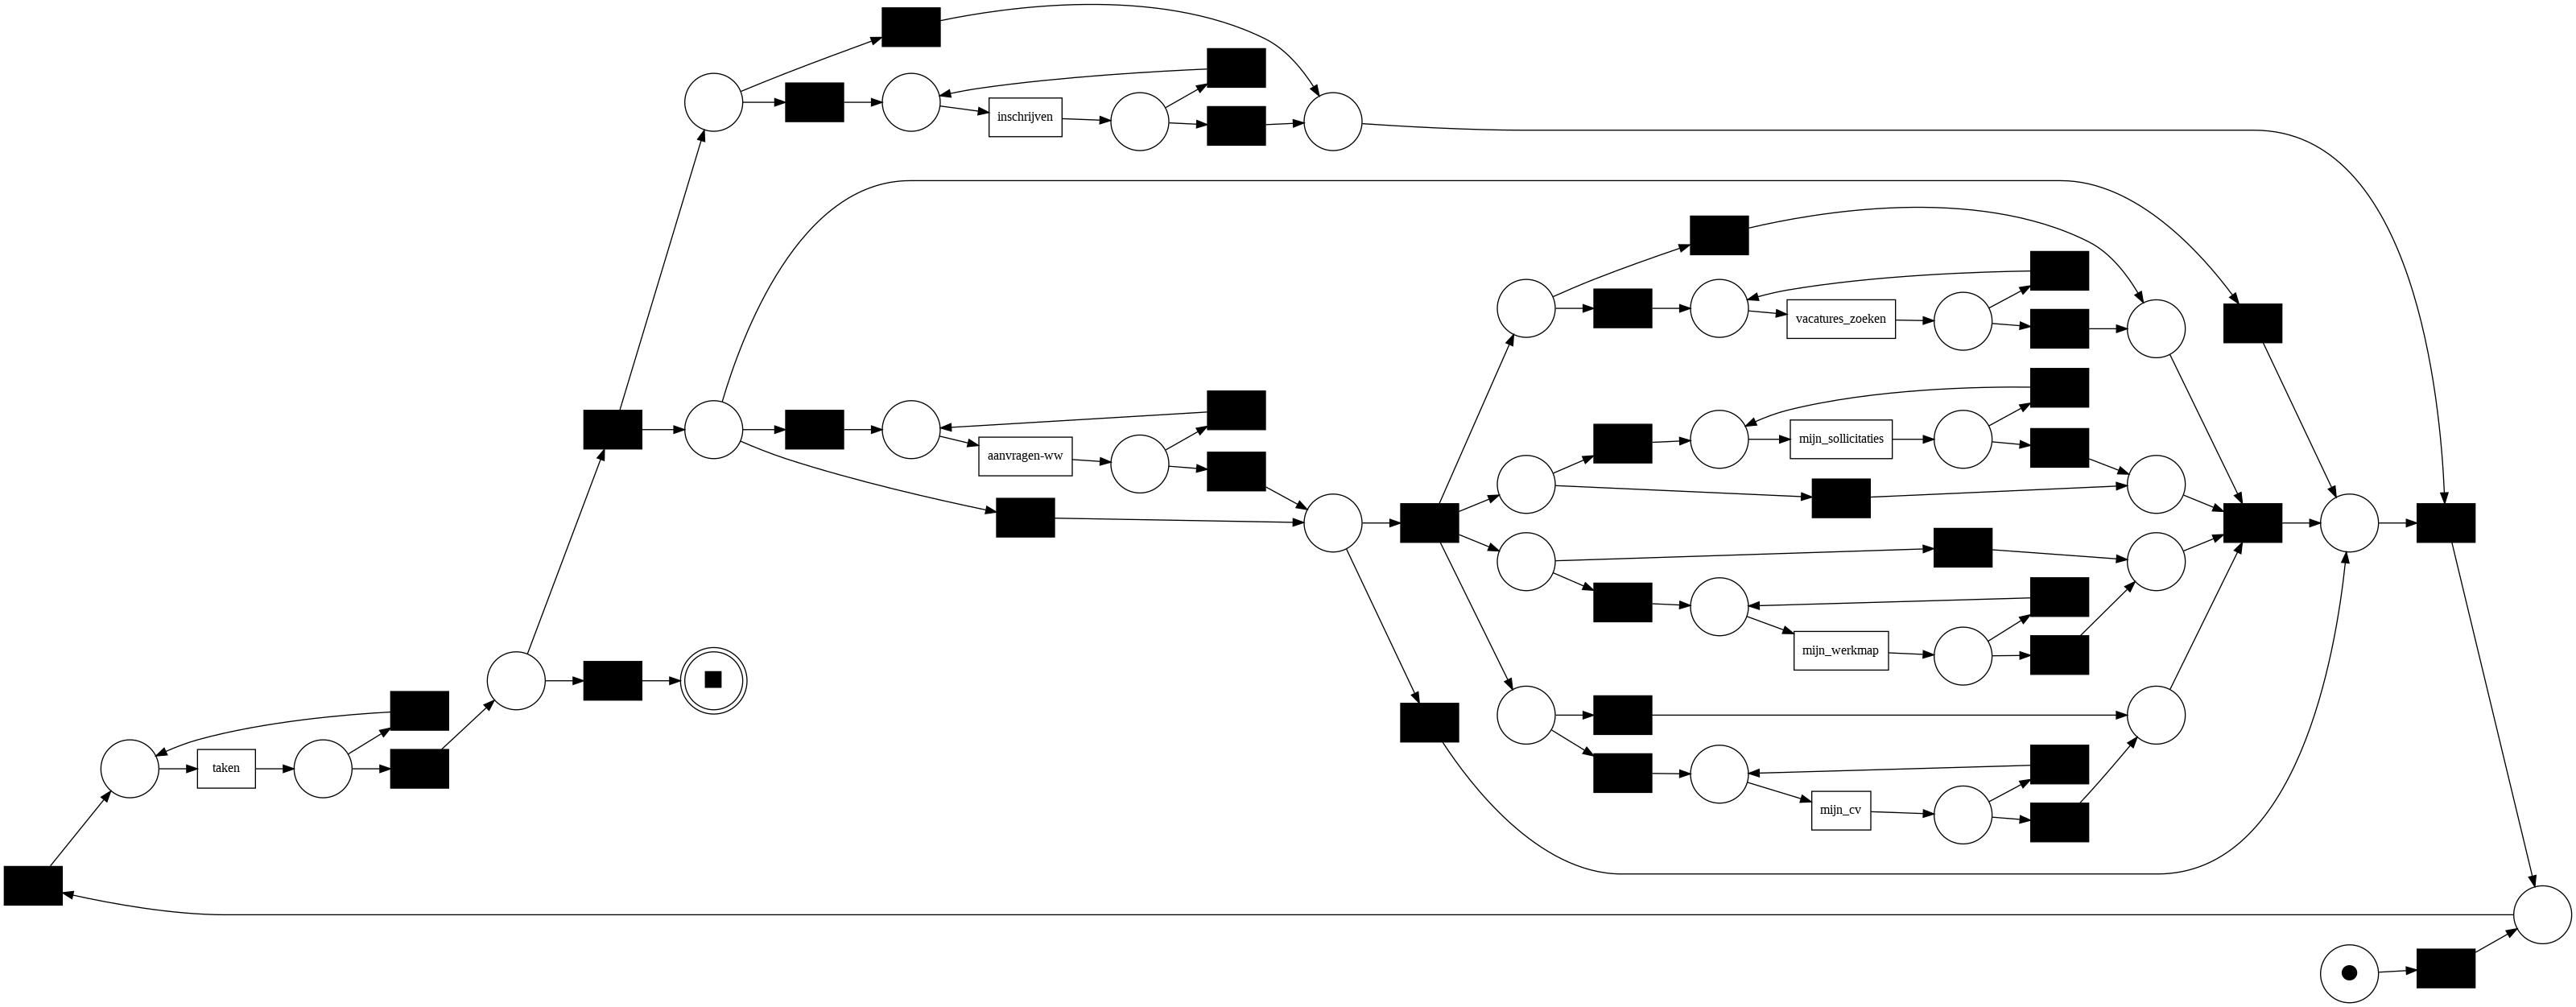

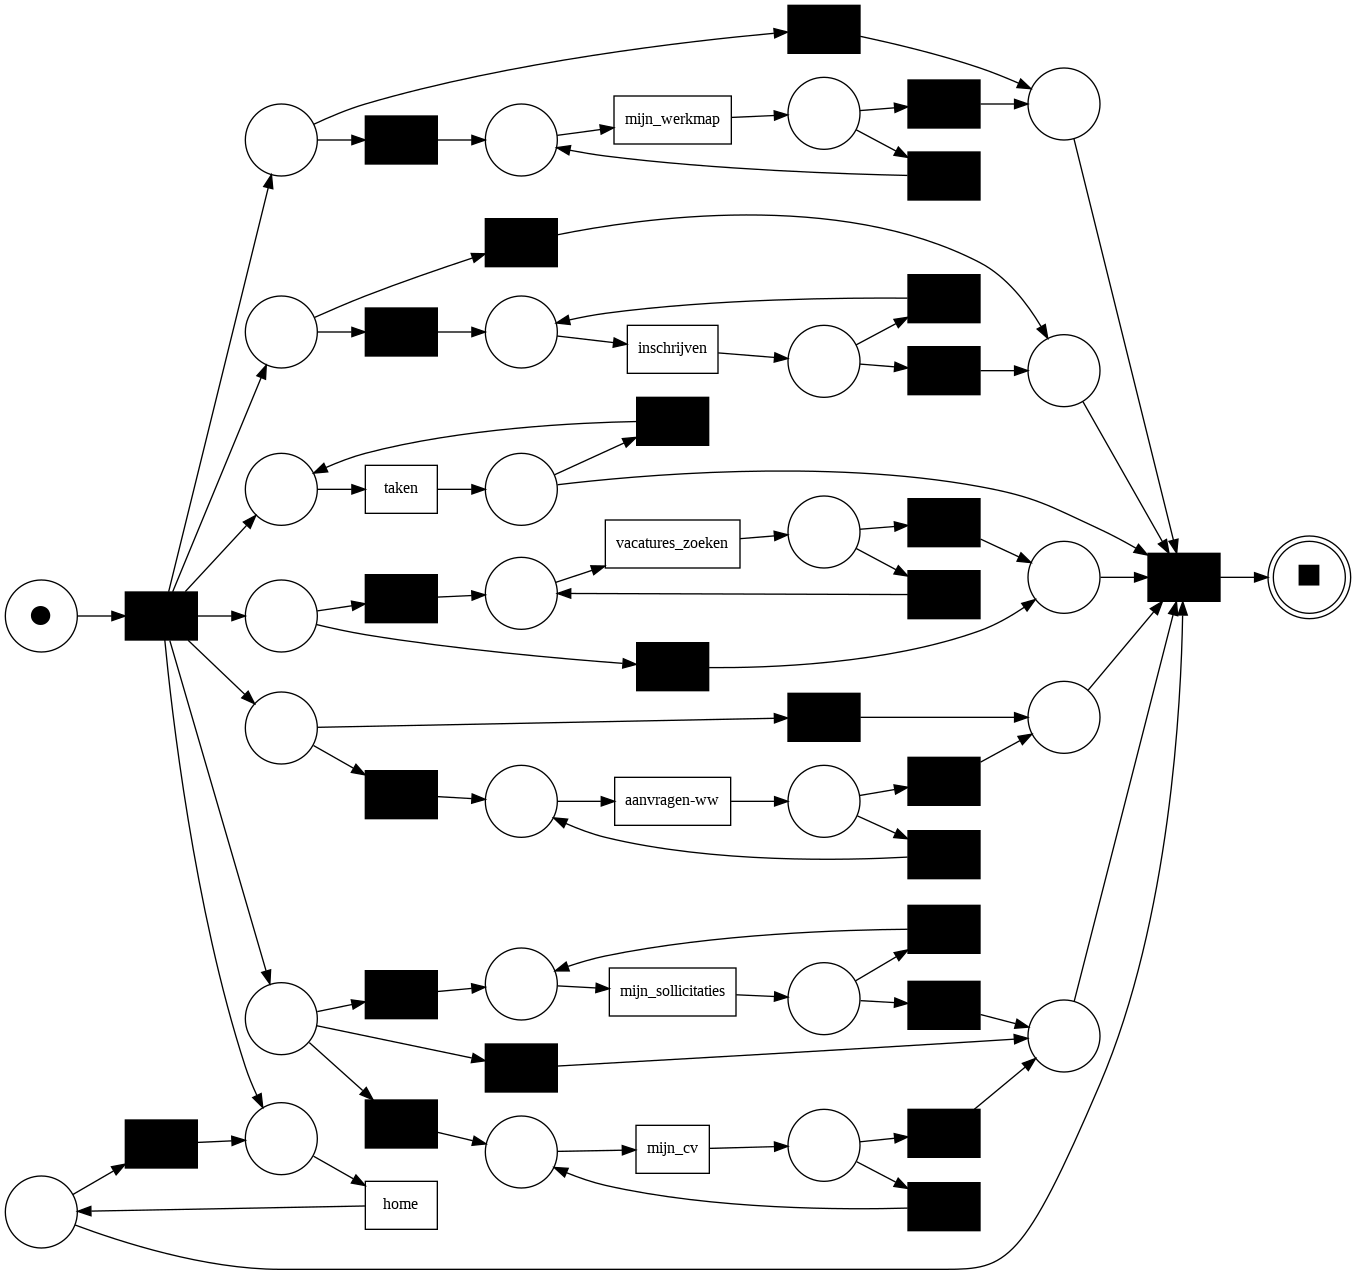

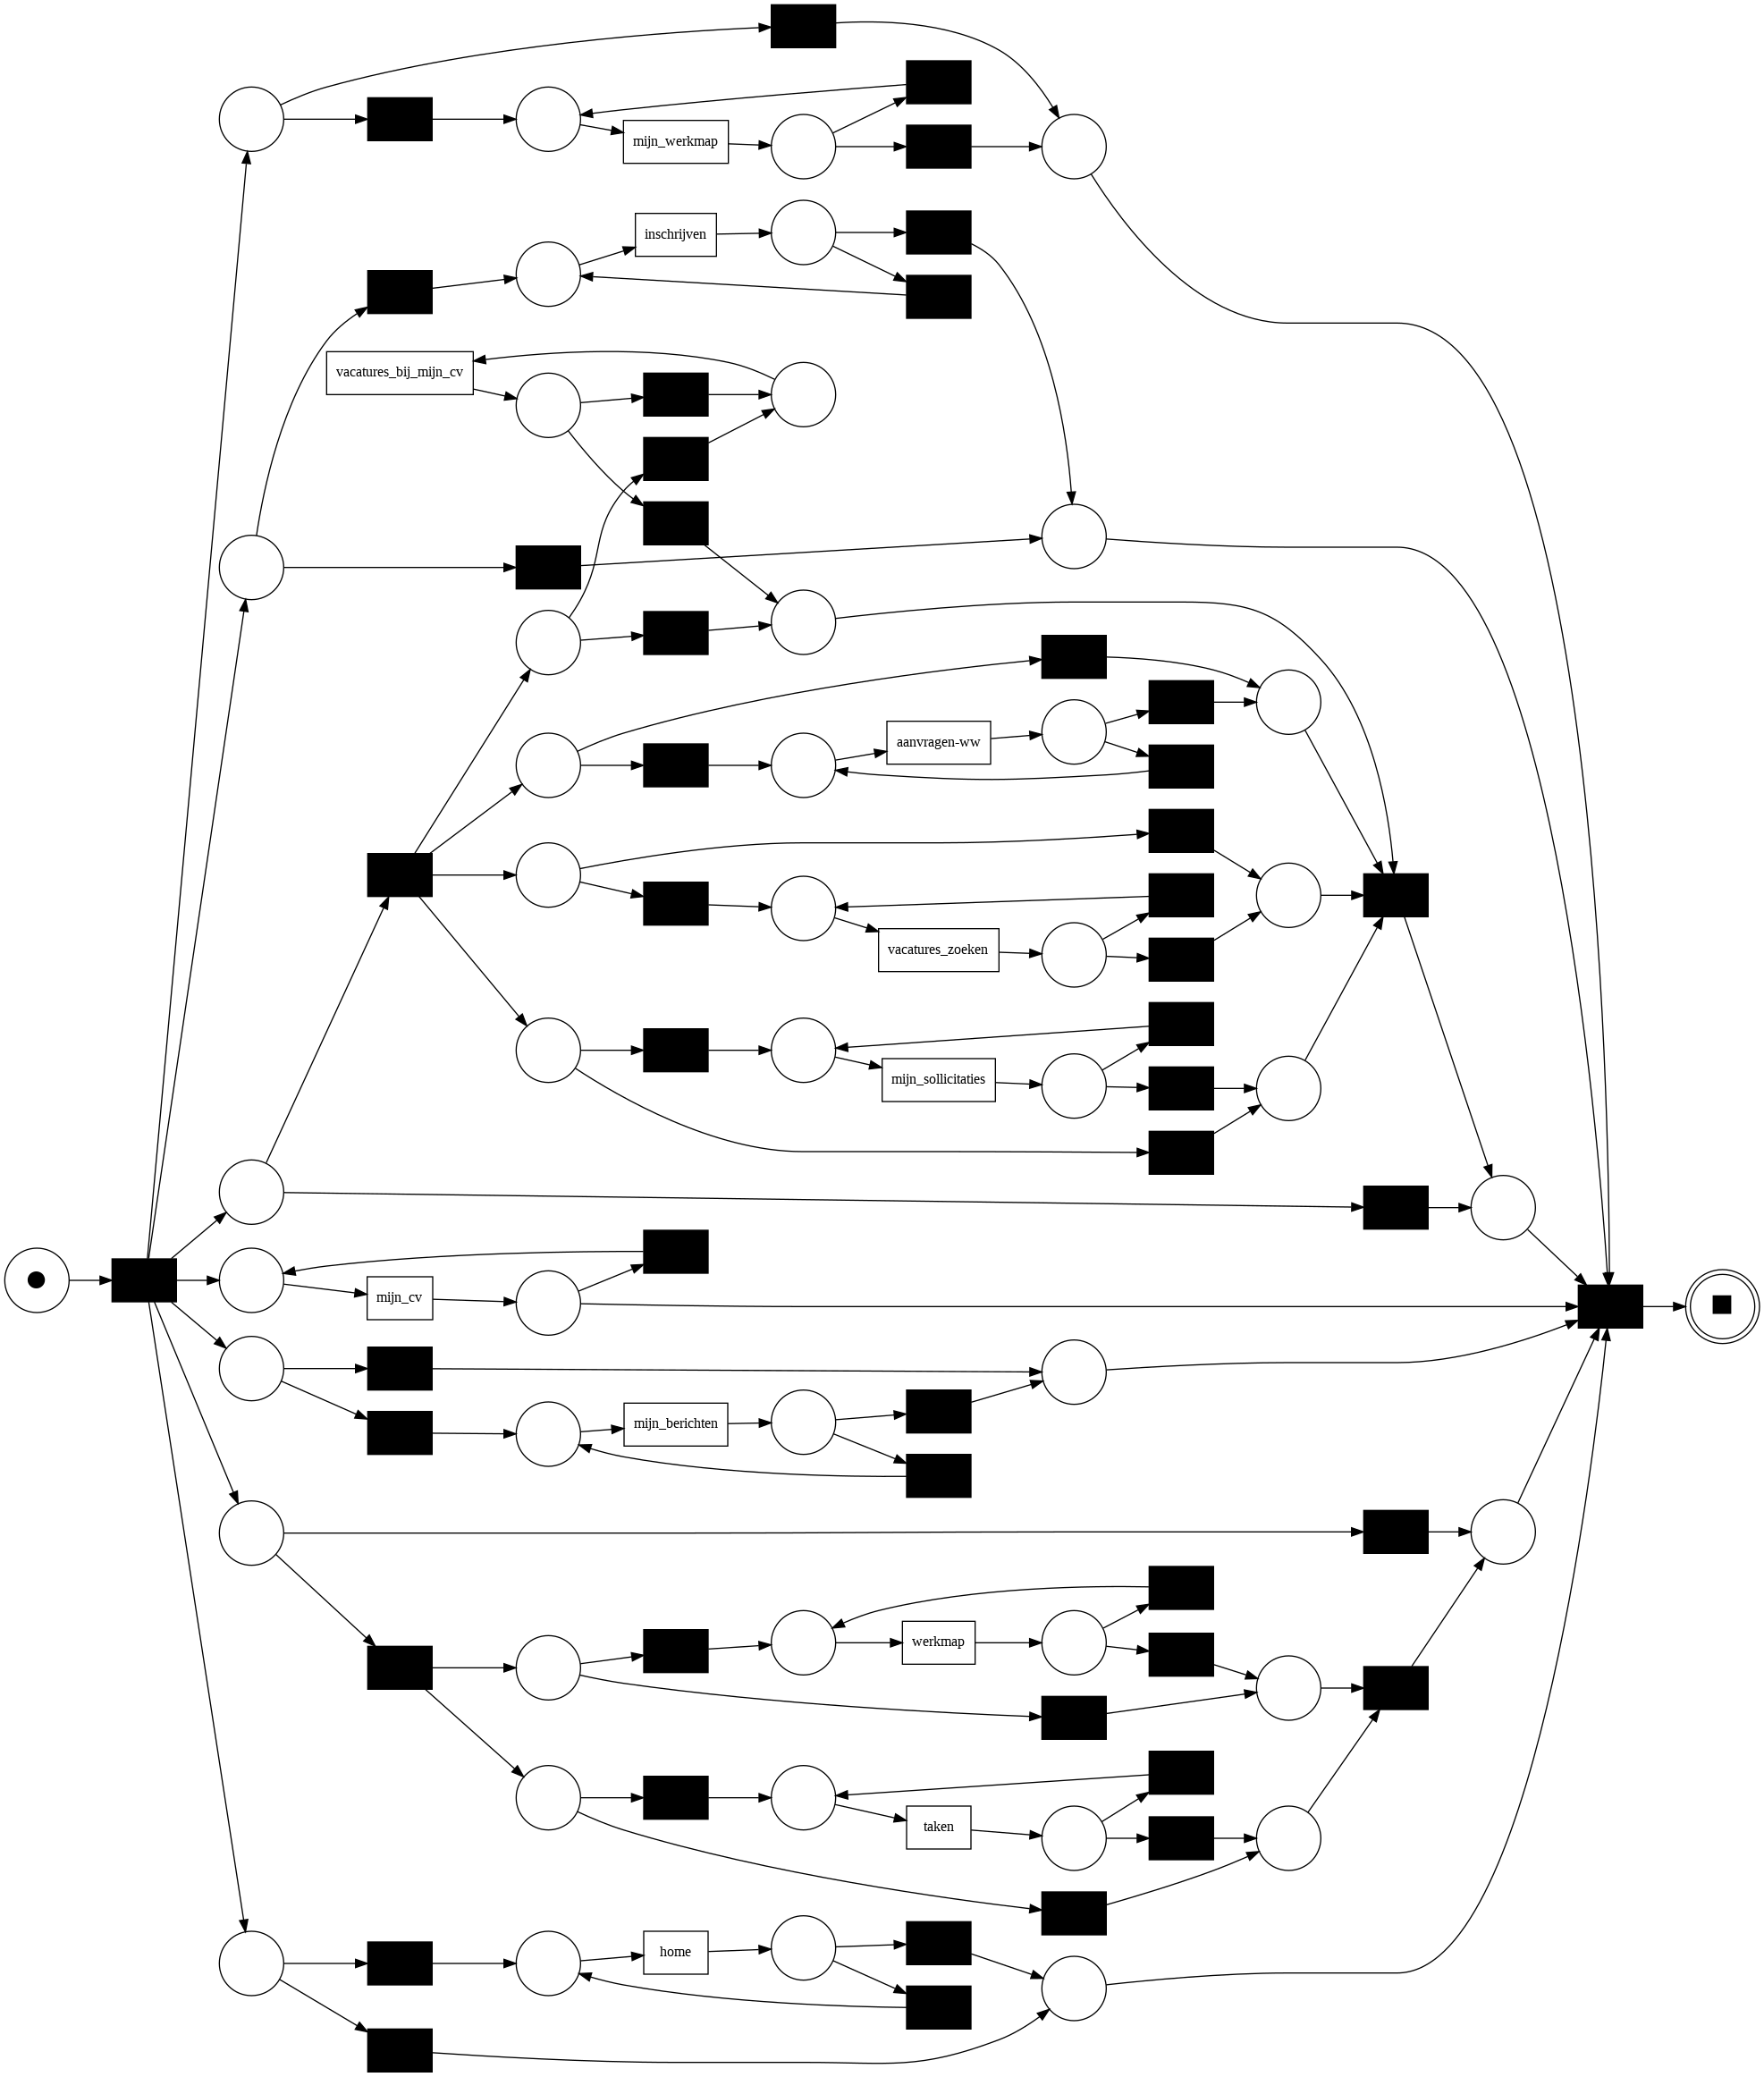

In [ ]:
for k in range(3):  #We only look at the first 3 models
  pm4py.view_petri_net(models[k][0], models[k][1], models[k][2])

I won't explain in detail every model, I will only focus in similarities. We already know that each model start and end with only 4 activities possible. Moreover, we already reduce the number of possible events to only 11. With this model, we can notice that there are a lot of parallel activities. Since we are talking about a website, we can assume that most people visit the same pages in different order. We also observe that almost every activitie can be repeat several times.

We can confirm our observations by looking at the activity rework graph performed on the whole event log.

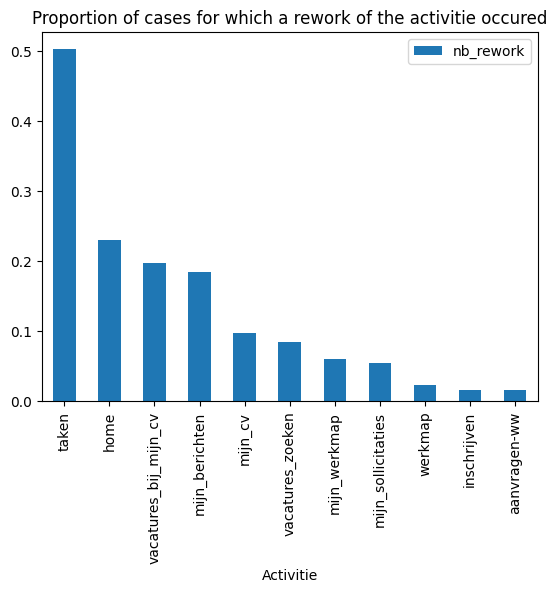

In [ ]:
rework = pm4py.get_rework_cases_per_activity(event_log)
rework_df = pd.DataFrame({'nb_rework':list(rework.values())},index=list(rework.keys()))
rework_df = rework_df.divide(len(event_log['case:concept:name'].unique()))
rework_df = rework_df.sort_values('nb_rework',ascending=False)
ax = rework_df.plot.bar(title='Proportion of cases for which a rework of the activitie occured',legend=True, xlabel='Activitie')


With this graph we can clearly see that some activities are often done multiple times in the same case. Is the case of the activity *taken* which is done more than once in 50% of the cases.This can be due to the fact that users have to switch pages to have more suggestions.This result is coherent with the observations we done on the models.

Finally, as we done before, we will look at proportion of men/women in each cluster and the distribution of the cases in the different age categories.
The goal is to find out if the different behaviours we observe depend on the age and the gender or not.

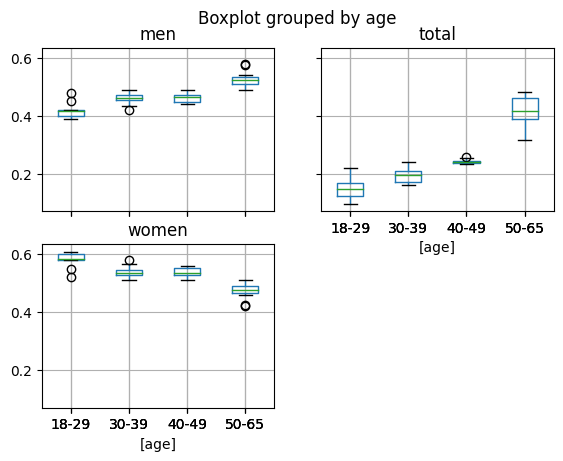

In [ ]:
for k in range(len(clusters_log)) :
  nb = len(clusters_log[k]['case:concept:name'].unique())
  for age in age_category:
    age_table = pm4py.filter_trace_attribute_values(clusters_log[k],'AgeCategory',[age])
    women_table = pm4py.filter_trace_attribute_values(age_table,'Gender',['V'])
    men_table = pm4py.filter_trace_attribute_values(age_table,'Gender',['M'])
    nb_women = len(women_table['case:concept:name'].unique())
    nb_men = len(men_table['case:concept:name'].unique())
    total = nb_women+nb_men
    stat_table.loc[len(stat_table)] = [nb_men/total,nb_women/total,total/nb,age]
boxplot = stat_table.boxplot(by='age')

On those graphs, we can clearly see that all the cluster are following the same pattern for the distribution of gender and  age. There are slight differences we can observe for the 18-29 and 50-65 age category but we still have the same idea.

# Conclusions
At the end of this study, we suceed to answer some questions. First, we saw that among all the cases there are around 25 clusters. On our focus on only 10 clusters, we arrived to the conclusion that even those cases can't be easily describe by Petri net. But we discovered that they have a lot in common. Indeed, they all share the same 11 different events whereas they are 600 events possible
Moreover all those clusters respect approximately the same pattern in terms of ratio men/women and distribution of the age of the population.
We saw that people are more looking for a job during the week than during the week-end.
We also observed that a large majority of cases are very short (around 10 minutes) and that some activitie like *taken* are done multiple times in many cases. 

Finally we can conclude that a large number of pages are useless for logged in people but it's hard to define a clear typical behaviour since each user has his own way to navigate through the website.It could be interesting to compare those results with a similar study done on the [Clicks NOT Logged In](https://data.4tu.nl/datasets/28ce6bee-7cd3-4cd8-bccd-f9226cc15f41) dataset to see if it's the same population and if the behaviour of the users are similar.